# Data Visualization

Este notebook apresenta uma análise visual do fenômeno de insucesso acadêmico a partir de um conjunto de dados previamente transformado na camada Silver do pipeline. Os dados foram originalmente extraídos de um relatório institucional e ingeridos na forma de arquivo Excel com abas por semestre, armazenado na camada Bronze. O objetivo é sintetizar evidências empíricas, em nível de disciplina, semestre e departamento, acerca da distribuição do insucesso, de sua evolução temporal e de suas variações relativas ao porte das turmas. Para isso, emprega-se uma abordagem exploratória e explicativa que combina medidas absolutas (contagens) e relativas (taxas normalizadas por número de discentes), bem como séries temporais por semestre para identificação de tendências.

O conjunto de dados utilizado é um arquivo CSV, `lista-insucesso-processed.csv`, com 610 registros e 14 variáveis. Entre as variáveis de maior relevância analítica destacam-se: Código e Nome da disciplina (identificadores textuais, sendo o prefixo de Código utilizado para derivar o Departamento), Discentes e Turmas (indicadores de porte e oferta), Cancelamentos e Trancamentos (eventos administrativos), o detalhamento das reprovações por critério (Média, Nota, Falta, combinações) e o Total Insucesso (medida agregada reportada pela fonte). O marcador temporal Semestre é representado como texto para preservar o formato do período (por exemplo, 2023.2, 2024.1) e permitir seu uso como eixo nas séries temporais.

Do ponto de vista metodológico, a análise organiza-se em três frentes complementares. Em primeiro lugar, realizam-se agregações por disciplina e por semestre com o intuito de construir rankings e identificar concentrações de insucesso. Em segundo lugar, avaliam-se trajetórias ao longo do tempo mediante gráficos de linha e ajuste de tendências, o que permite reconhecer movimentos de aumento, redução ou estabilidade. Em terceiro lugar, produzem-se comparativos entre departamentos, com indicadores de eficiência (alunos por turma) e de qualidade (taxa de insucesso em percentuais), de modo a contextualizar resultados em função de diferenças de escala e oferta.

O desenho visual prioriza representações que maximizam legibilidade e comparabilidade: barras horizontais para ordenação e leitura de rankings, séries temporais com marcações e rotulações para facilitar a interpretação de variações, e anotações diretas para explicitar valores relevantes. A preparação prévia dos dados, realizada no notebook de ETL, assegura padronização de tipos, enriquecimento com atributos derivados e consolidação entre semestres, o que contribui para a consistência das inferências. Embora o Total Insucesso seja consumido tal como fornecido pela fonte, reconhece-se que análises explicativas sobre causas demandariam variáveis adicionais (por exemplo, perfil discente, pré-requisitos ou carga horária). Por fim, as rotinas aqui apresentadas foram estruturadas para reprodutibilidade, com leitura padronizada do CSV e parametrizações que viabilizam a atualização do estudo à medida que novos semestres forem incorporados ao pipeline.

In [ ]:
# Comentário: inspeção inicial do CSV consolidado (forma, colunas, tipos, semestres), estatísticas básicas e checagem de valores ausentes para validar a integridade antes das análises.
# Visão geral programática dos dados (executar antes das análises)
import pandas as pd
import numpy as np

# Leitura independente para garantir reprodutibilidade desta seção
_df = pd.read_csv("lista-insucesso-processed.csv", sep=";", encoding="utf-8")

print("Formato:", _df.shape)
print("Colunas:", list(_df.columns))
print("Tipos:\n", _df.dtypes)
print("\nSemestres:", sorted(_df['Semestre'].unique()))

# Estatísticas descritivas selecionadas
cols_numericas = [
    'Turmas','Discentes','Cancelamentos','Trancamentos',
    'Reprovações Média','Reprovações Nota','Reprovações Falta',
    'Reprovações Média e Falta','Reprovações Nota e Falta','Total Insucesso'
]
print("\nResumo numérico:\n", _df[cols_numericas].describe().T)

# Verificações simples
missing = _df.isna().sum()
print("\nValores ausentes por coluna:\n", missing[missing>0])

# Amostra das primeiras linhas
_df.head(3)


Formato: (610, 14)
Colunas: ['Código', 'Nome', 'Turmas', 'Discentes', 'Cancelamentos', 'Reprovações Média', 'Reprovações Nota', 'Reprovações Falta', 'Reprovações Média e Falta', 'Reprovações Nota e Falta', 'Trancamentos', 'Total Insucesso', 'Semestre', 'Departamento']
Tipos:
 Código                        object
Nome                          object
Turmas                         int64
Discentes                      int64
Cancelamentos                  int64
Reprovações Média              int64
Reprovações Nota               int64
Reprovações Falta              int64
Reprovações Média e Falta      int64
Reprovações Nota e Falta       int64
Trancamentos                   int64
Total Insucesso                int64
Semestre                     float64
Departamento                  object
dtype: object

Semestres: [np.float64(2023.2), np.float64(2024.1), np.float64(2024.2), np.float64(2025.1)]

Resumo numérico:
                            count       mean        std  min  25%  50%    75%  \

,Código,Nome,Turmas,Discentes,Cancelamentos,Reprovações Média,Reprovações Nota,Reprovações Falta,Reprovações Média e Falta,Reprovações Nota e Falta,Trancamentos,Total Insucesso,Semestre,Departamento
0,ADM0014,ADMINISTRAÇÃO PÚBLICA E GESTÃO SOCIAL,1,1,0,0,0,0,0,0,0,0,2023.2,ADM
1,FGA0038,AERODINÂMICA DE SISTEMAS AEROESPACIAIS,1,1,0,0,0,0,0,0,1,1,2023.2,FGA
2,FUP0545,AGRICULTURA E MEIO AMBIENTE,1,1,0,1,0,0,0,0,0,1,2023.2,FUP


In [ ]:
# Comentário: importações principais — pandas (dados tabulares), seaborn/matplotlib (visualização), numpy (cálculos numéricos e regressão para linhas de tendência).
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


## Read Data

In [ ]:
# Comentário: carrega o dataset consolidado do ETL (CSV com separador ';') e exibe uma amostra para confirmar o carregamento.
dataframe = pd.read_csv("lista-insucesso-processed.csv", sep=";", encoding="utf-8")
dataframe

,Código,Nome,Turmas,Discentes,Cancelamentos,Reprovações Média,Reprovações Nota,Reprovações Falta,Reprovações Média e Falta,Reprovações Nota e Falta,Trancamentos,Total Insucesso,Semestre,Departamento
0,ADM0014,ADMINISTRAÇÃO PÚBLICA E GESTÃO SOCIAL,1,1,0,0,0,0,0,0,0,0,2023.2,ADM
1,FGA0038,AERODINÂMICA DE SISTEMAS AEROESPACIAIS,1,1,0,0,0,0,0,0,1,1,2023.2,FGA
2,FUP0545,AGRICULTURA E MEIO AMBIENTE,1,1,0,1,0,0,0,0,0,1,2023.2,FUP
3,FUP0161,AGROECOLOGIA,1,1,0,0,0,1,0,0,0,1,2023.2,FUP
4,MAT0039,ALGEBRA LINEAR,1,1,0,0,0,0,0,0,0,0,2023.2,MAT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,FGA0214,TÓPICOS ESPECIAIS EM ENGENHARIA AUTOMOTIVA,1,1,0,0,0,0,0,0,1,1,2025.1,FGA
606,FGA0054,TÓPICOS ESPECIAIS EM GOVERNANÇA DE TECNOLOGIA ...,1,30,0,0,0,0,0,0,1,1,2025.1,FGA
607,FGA0053,TÓPICOS ESPECIAIS EM PROGRAMAÇÃO,1,32,1,0,0,3,0,0,11,15,2025.1,FGA
608,CEM0015,"UNIVERSIDADE, SOCIEDADE E ESTADO",1,1,0,0,0,1,0,0,0,1,2025.1,CEM


## Top Failures

/tmp/ipykernel_9416/1609614148.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


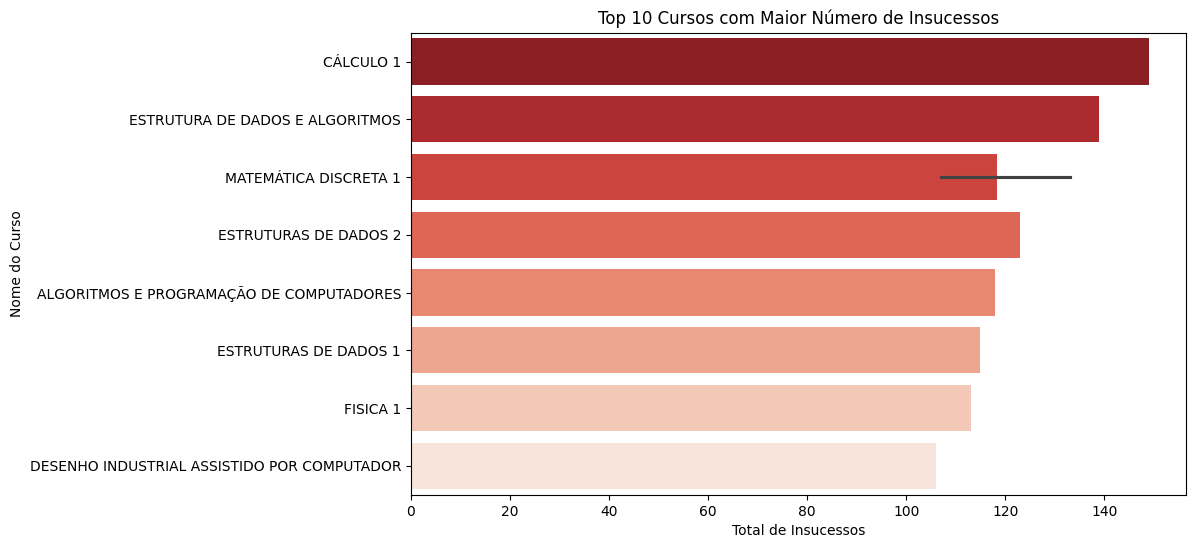

In [ ]:
# Comentário: seleciona as 10 disciplinas com maior Total de Insucesso e plota barras horizontais para comunicar o ranking de forma legível.
top_failures = dataframe.nlargest(10, "Total Insucesso")[["Nome", "Total Insucesso"]]

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_failures,
    x="Total Insucesso",
    y="Nome",
    palette="Reds_r"
)

plt.xlabel("Total de Insucessos")
plt.ylabel("Nome do Curso")
plt.title("Top 10 Cursos com Maior Número de Insucessos")
plt.show()

## Failures per Semester

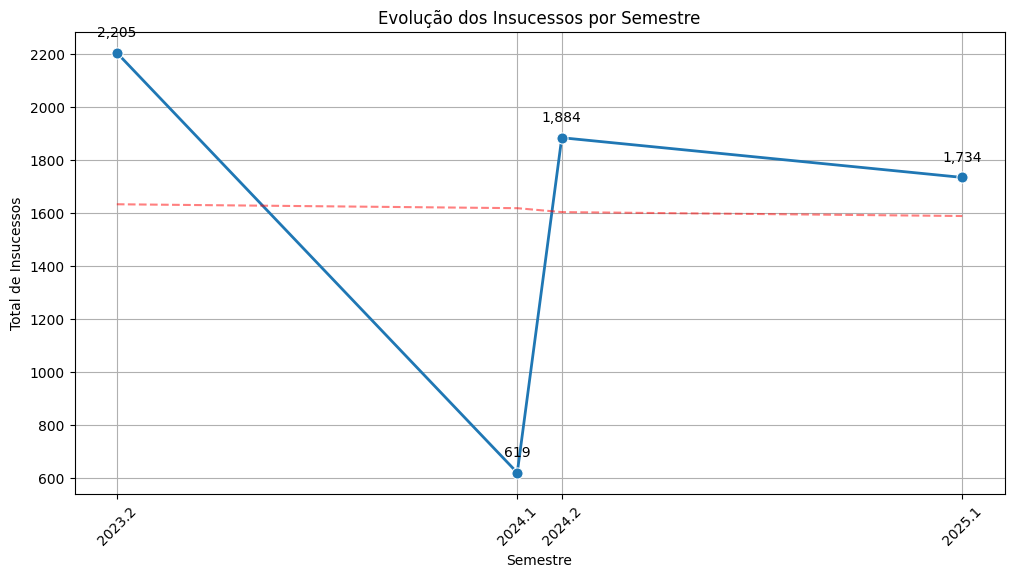

In [ ]:
# Comentário: agrega o Total de Insucesso por semestre, plota uma série temporal e adiciona uma linha de tendência por regressão linear (numpy.polyfit) para indicar direção geral.
semesterly_failures = dataframe.groupby("Semestre")["Total Insucesso"].sum().reset_index()

plt.subplots(figsize=(12, 6))
sns.lineplot(
    data=semesterly_failures,
    x="Semestre",
    y="Total Insucesso",
    marker="o",
    linewidth=2,
    markersize=8,
)

plt.xticks(semesterly_failures["Semestre"], rotation=45)

for x, y in zip(semesterly_failures["Semestre"], semesterly_failures["Total Insucesso"]):
    plt.text(x, y+ 50, f'{y:,.0f}', ha='center', va='bottom')

z = np.polyfit(range(len(semesterly_failures)), semesterly_failures['Total Insucesso'], 1)
p = np.poly1d(z)
plt.plot(semesterly_failures['Semestre'], p(range(len(semesterly_failures))), 
         linestyle='--', color='red', alpha=0.5, label='Tendência')


plt.xlabel("Semestre")
plt.ylabel("Total de Insucessos")
plt.title("Evolução dos Insucessos por Semestre")
plt.grid(True)
plt.show()

Disciplina selecionada: CÁLCULO 1
Código: MAT0025
Total de insucessos: 149

Dados encontrados para 4 semestre(s):
------------------------------------------------------------
Semestre 2023.2: 149 insucessos (306 discentes)
Semestre 2024.1: 29 insucessos (171 discentes)
Semestre 2024.2: 60 insucessos (107 discentes)
Semestre 2025.1: 26 insucessos (45 discentes)


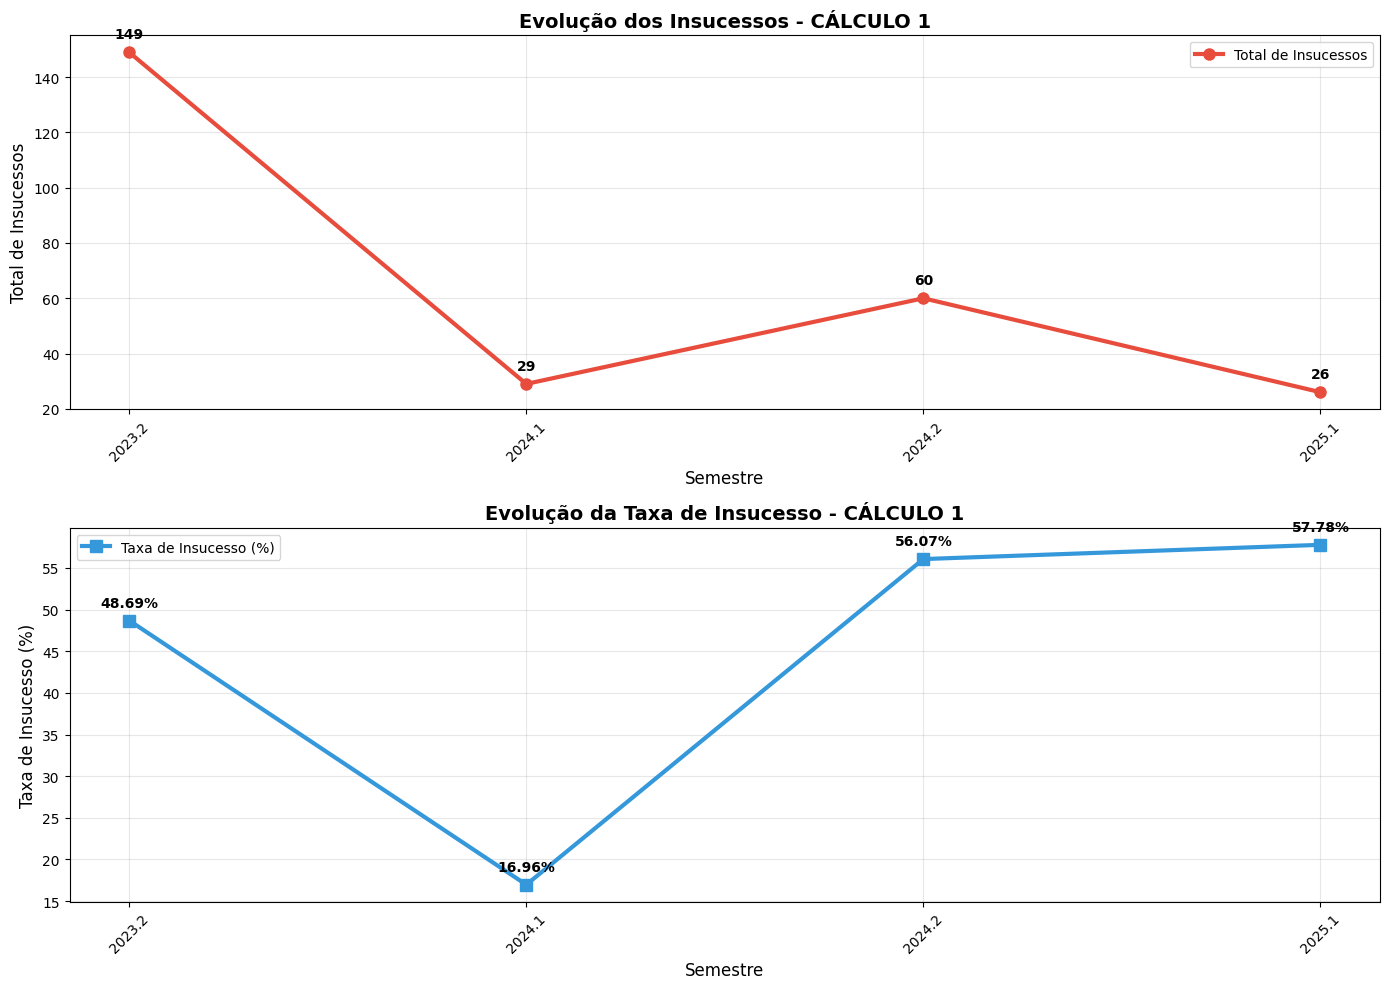


Análise de Tendência:
----------------------------------------
Tendência Total de Insucessos: ↘ Diminuindo
Tendência Taxa de Insucesso: ↗ Aumentando
Variação Total: -82.6%
Variação Taxa: +18.7%


In [ ]:
# Comentário: escolhe automaticamente a disciplina com maior Total de Insucesso e cria duas séries: (1) total absoluto por semestre e (2) taxa (%) normalizada por Discentes. Também calcula tendências lineares se houver mais de um ponto temporal.
disciplina_maior_insucesso = dataframe.loc[dataframe['Total Insucesso'].idxmax()]
nome_disciplina = disciplina_maior_insucesso['Nome']
codigo_disciplina = disciplina_maior_insucesso['Código']

print(f"Disciplina selecionada: {nome_disciplina}")
print(f"Código: {codigo_disciplina}")
print(f"Total de insucessos: {disciplina_maior_insucesso['Total Insucesso']}")

disciplina_data = dataframe[dataframe['Nome'] == nome_disciplina].copy()
disciplina_data = disciplina_data.sort_values('Semestre')

print(f"\nDados encontrados para {len(disciplina_data)} semestre(s):")
print("-" * 60)
for _, row in disciplina_data.iterrows():
    print(f"Semestre {row['Semestre']}: {row['Total Insucesso']} insucessos ({row['Discentes']} discentes)")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

x_positions = range(len(disciplina_data))
semestre_labels = disciplina_data['Semestre'].tolist()

ax1.plot(x_positions, disciplina_data['Total Insucesso'], 
         marker='o', linewidth=3, markersize=8, color='#e74c3c', label='Total de Insucessos')

for i, (x, y) in enumerate(zip(x_positions, disciplina_data['Total Insucesso'])):
    ax1.annotate(f'{y}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontweight='bold')

ax1.set_xlabel('Semestre', fontsize=12)
ax1.set_ylabel('Total de Insucessos', fontsize=12)
ax1.set_title(f'Evolução dos Insucessos - {nome_disciplina}', fontsize=14, fontweight='bold')
ax1.set_xticks(x_positions)
ax1.set_xticklabels(semestre_labels, rotation=45)
ax1.grid(True, alpha=0.3)
ax1.legend()

taxa_insucesso = (disciplina_data['Total Insucesso'] / disciplina_data['Discentes'] * 100).round(2)
ax2.plot(x_positions, taxa_insucesso, 
         marker='s', linewidth=3, markersize=8, color='#3498db', label='Taxa de Insucesso (%)')

for i, (x, y) in enumerate(zip(x_positions, taxa_insucesso)):
    ax2.annotate(f'{y}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontweight='bold')

ax2.set_xlabel('Semestre', fontsize=12)
ax2.set_ylabel('Taxa de Insucesso (%)', fontsize=12)
ax2.set_title(f'Evolução da Taxa de Insucesso - {nome_disciplina}', fontsize=14, fontweight='bold')
ax2.set_xticks(x_positions)
ax2.set_xticklabels(semestre_labels, rotation=45)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

if len(disciplina_data) > 1:
    x_numeric = range(len(disciplina_data))
    z_total = np.polyfit(x_numeric, disciplina_data['Total Insucesso'], 1)
    z_taxa = np.polyfit(x_numeric, taxa_insucesso, 1)
    
    print(f"\nAnálise de Tendência:")
    print("-" * 40)
    print(f"Tendência Total de Insucessos: {'↗ Aumentando' if z_total[0] > 0 else '↘ Diminuindo' if z_total[0] < 0 else '→ Estável'}")
    print(f"Tendência Taxa de Insucesso: {'↗ Aumentando' if z_taxa[0] > 0 else '↘ Diminuindo' if z_taxa[0] < 0 else '→ Estável'}")
    
    if len(disciplina_data) >= 2:
        variacao_total = ((disciplina_data['Total Insucesso'].iloc[-1] - disciplina_data['Total Insucesso'].iloc[0]) / disciplina_data['Total Insucesso'].iloc[0] * 100)
        variacao_taxa = ((taxa_insucesso.iloc[-1] - taxa_insucesso.iloc[0]) / taxa_insucesso.iloc[0] * 100)
        print(f"Variação Total: {variacao_total:+.1f}%")
        print(f"Variação Taxa: {variacao_taxa:+.1f}%")


In [ ]:
# Comentário: soma componentes de reprovação para contextualizar o Total de Insucesso e entender contribuições por tipo (nota, falta e combinações).
total_reprovações = dataframe[["Reprovações Nota", "Reprovações Falta", "Reprovações Média e Falta", "Reprovações Nota e Falta"]].sum()
total_reprovações

Reprovações Nota               0
Reprovações Falta            886
Reprovações Média e Falta      0
Reprovações Nota e Falta       0
dtype: int64

Semestres encontrados: [np.float64(2023.2), np.float64(2024.1), np.float64(2024.2), np.float64(2025.1)]
Total de semestres: 4


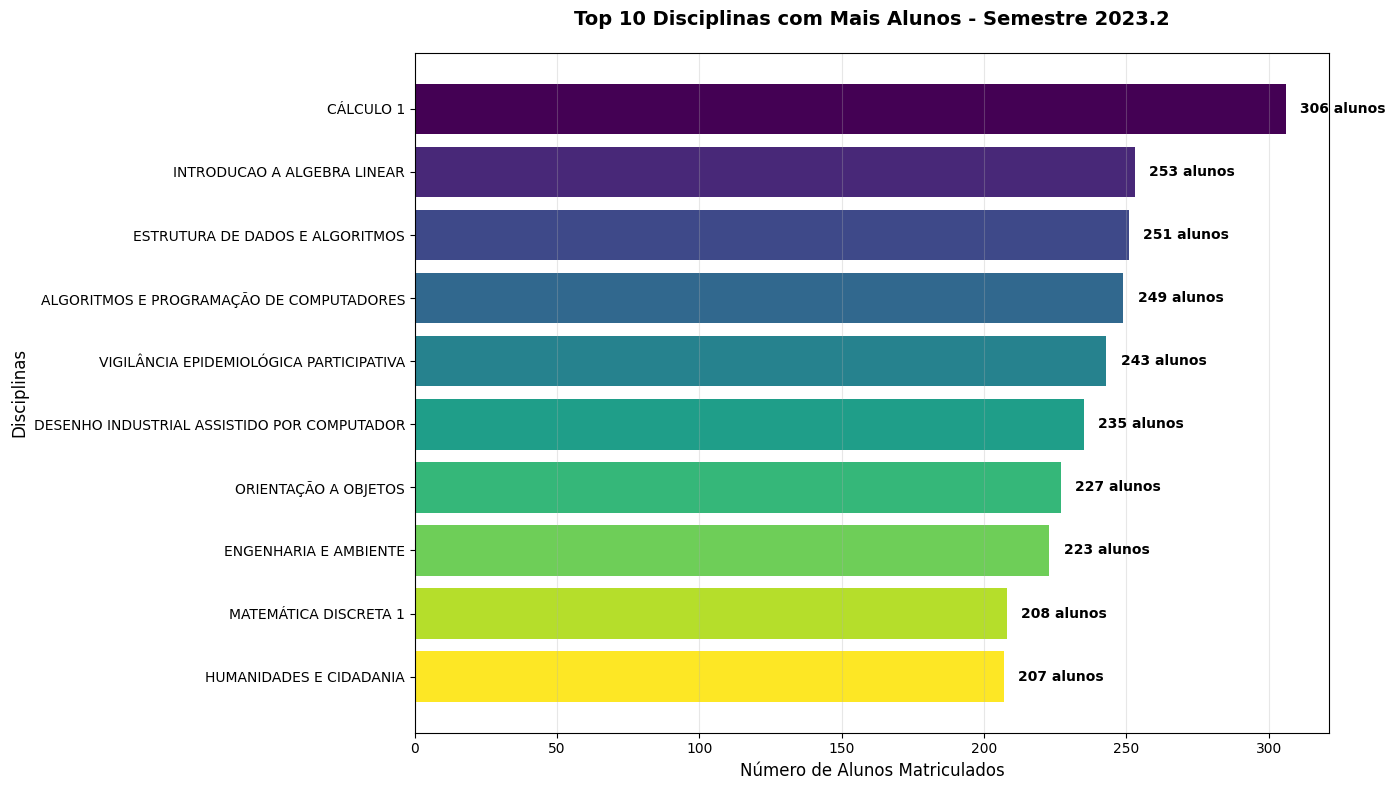


Resumo do Semestre 2023.2:
--------------------------------------------------------------------------------
Pos Nome da Disciplina                                 Alunos   Turmas 
--------------------------------------------------------------------------------
1   CÁLCULO 1                                          306      8      
2   INTRODUCAO A ALGEBRA LINEAR                        253      11     
3   ESTRUTURA DE DADOS E ALGORITMOS                    251      3      
4   ALGORITMOS E PROGRAMAÇÃO DE COMPUTADORES           249      6      
5   VIGILÂNCIA EPIDEMIOLÓGICA PARTICIPATIVA            243      4      
6   DESENHO INDUSTRIAL ASSISTIDO POR COMPUTADOR        235      6      
7   ORIENTAÇÃO A OBJETOS                               227      4      
8   ENGENHARIA E AMBIENTE                              223      3      
9   MATEMÁTICA DISCRETA 1                              208      2      
10  HUMANIDADES E CIDADANIA                            207      4      

Estatísticas do S

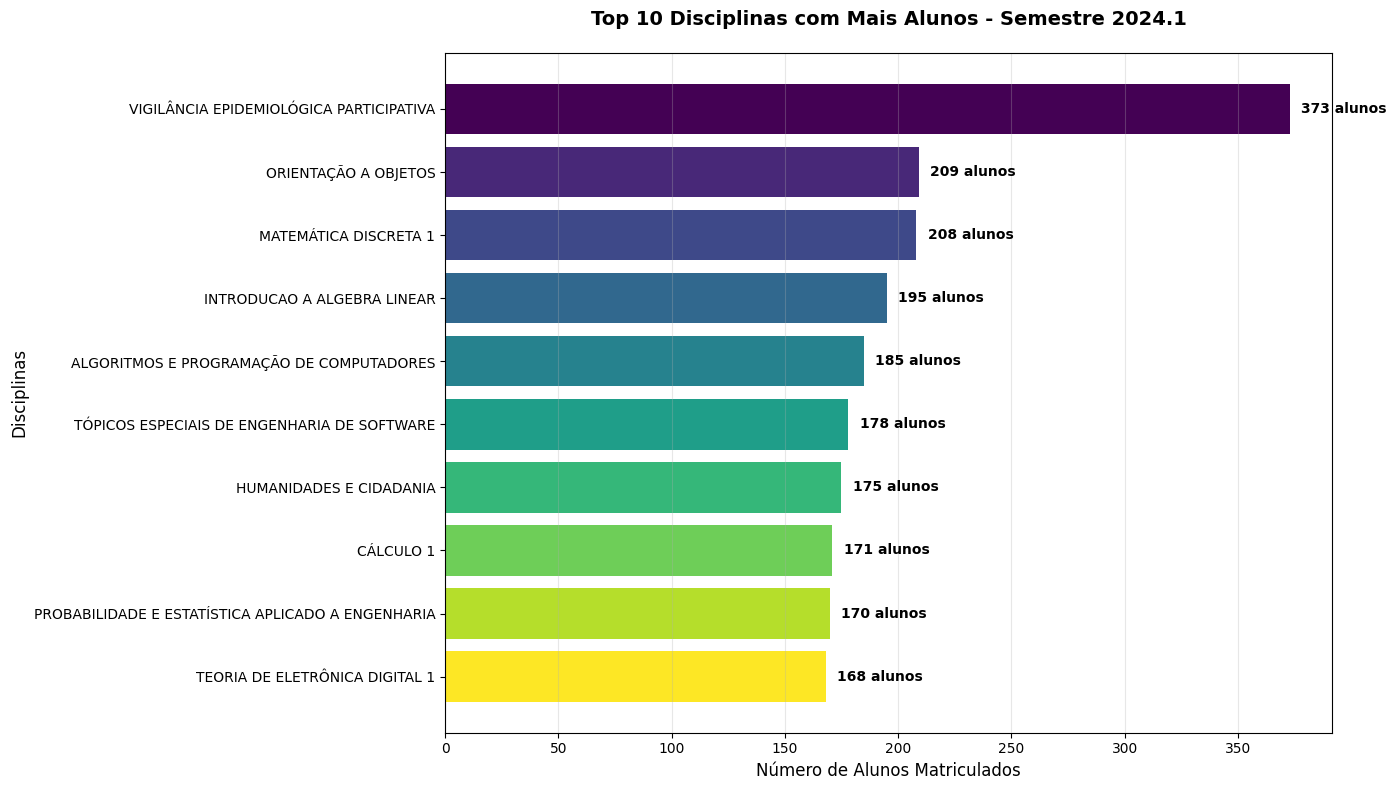


Resumo do Semestre 2024.1:
--------------------------------------------------------------------------------
Pos Nome da Disciplina                                 Alunos   Turmas 
--------------------------------------------------------------------------------
1   VIGILÂNCIA EPIDEMIOLÓGICA PARTICIPATIVA            373      1      
2   ORIENTAÇÃO A OBJETOS                               209      5      
3   MATEMÁTICA DISCRETA 1                              208      3      
4   INTRODUCAO A ALGEBRA LINEAR                        195      12     
5   ALGORITMOS E PROGRAMAÇÃO DE COMPUTADORES           185      7      
6   TÓPICOS ESPECIAIS DE ENGENHARIA DE SOFTWARE        178      2      
7   HUMANIDADES E CIDADANIA                            175      4      
8   CÁLCULO 1                                          171      5      
9   PROBABILIDADE E ESTATÍSTICA APLICADO A ENGENHARI   170      2      
10  TEORIA DE ELETRÔNICA DIGITAL 1                     168      2      

Estatísticas do S

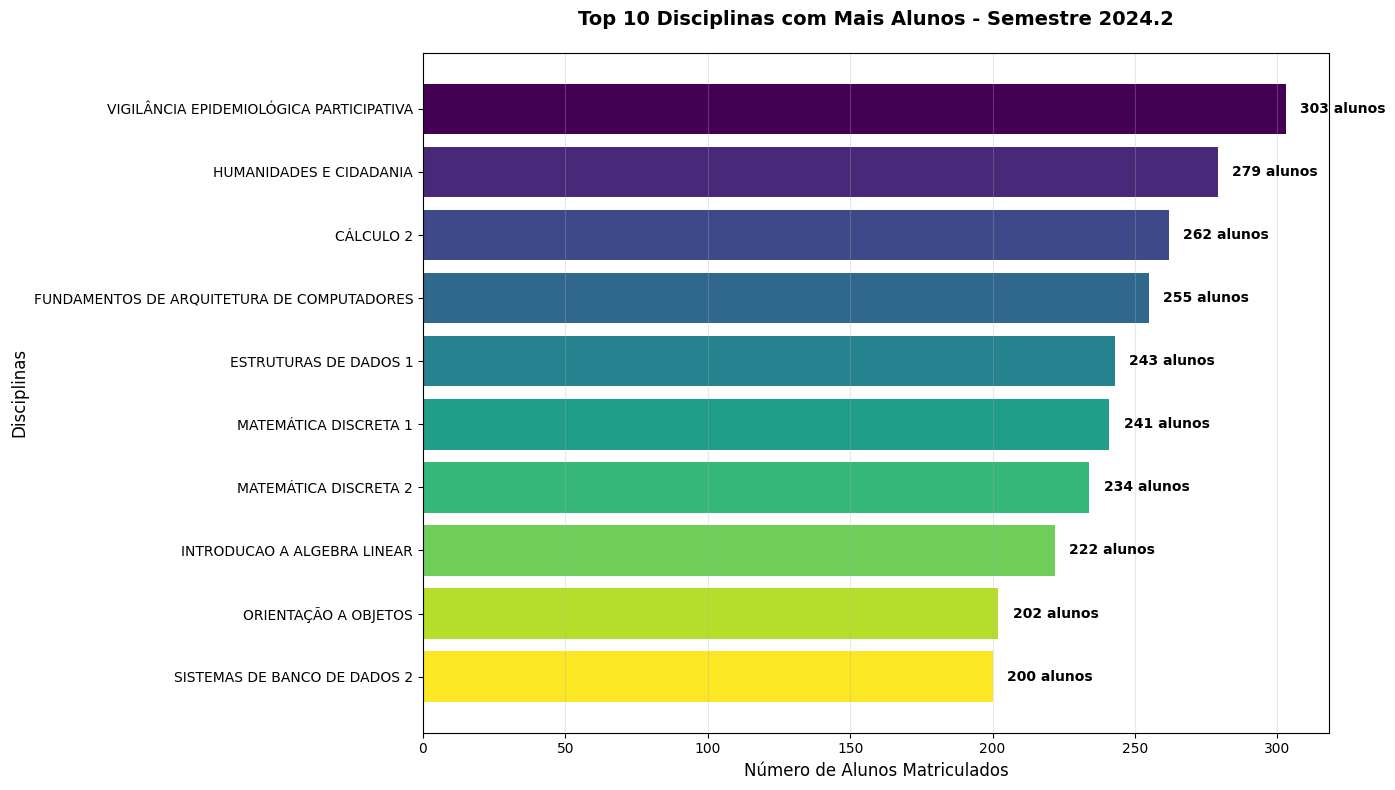


Resumo do Semestre 2024.2:
--------------------------------------------------------------------------------
Pos Nome da Disciplina                                 Alunos   Turmas 
--------------------------------------------------------------------------------
1   VIGILÂNCIA EPIDEMIOLÓGICA PARTICIPATIVA            303      1      
2   HUMANIDADES E CIDADANIA                            279      4      
3   CÁLCULO 2                                          262      7      
4   FUNDAMENTOS DE ARQUITETURA DE COMPUTADORES         255      2      
5   ESTRUTURAS DE DADOS 1                              243      3      
6   MATEMÁTICA DISCRETA 1                              241      2      
7   MATEMÁTICA DISCRETA 2                              234      3      
8   INTRODUCAO A ALGEBRA LINEAR                        222      9      
9   ORIENTAÇÃO A OBJETOS                               202      4      
10  SISTEMAS DE BANCO DE DADOS 2                       200      3      

Estatísticas do S

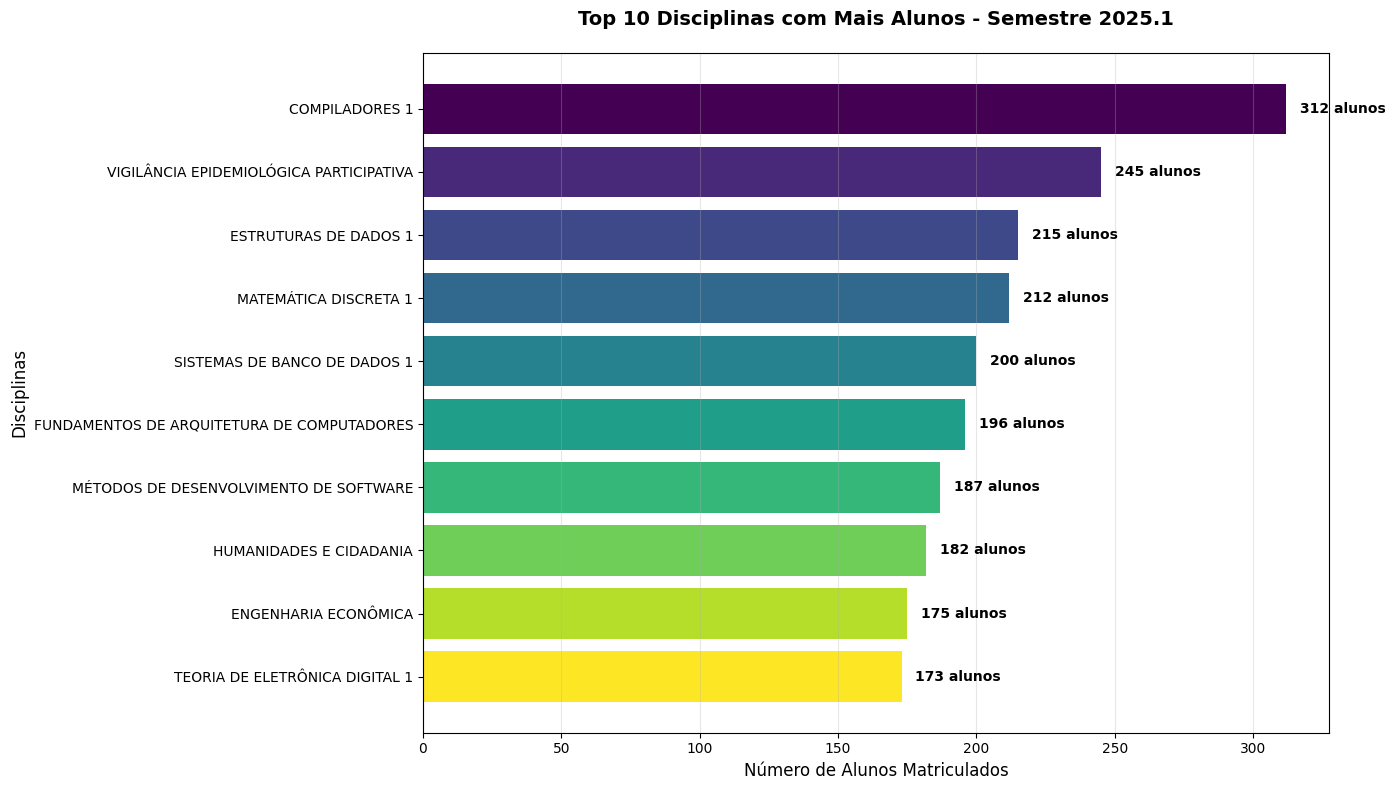


Resumo do Semestre 2025.1:
--------------------------------------------------------------------------------
Pos Nome da Disciplina                                 Alunos   Turmas 
--------------------------------------------------------------------------------
1   COMPILADORES 1                                     312      3      
2   VIGILÂNCIA EPIDEMIOLÓGICA PARTICIPATIVA            245      1      
3   ESTRUTURAS DE DADOS 1                              215      2      
4   MATEMÁTICA DISCRETA 1                              212      2      
5   SISTEMAS DE BANCO DE DADOS 1                       200      3      
6   FUNDAMENTOS DE ARQUITETURA DE COMPUTADORES         196      2      
7   MÉTODOS DE DESENVOLVIMENTO DE SOFTWARE             187      3      
8   HUMANIDADES E CIDADANIA                            182      4      
9   ENGENHARIA ECONÔMICA                               175      2      
10  TEORIA DE ELETRÔNICA DIGITAL 1                     173      3      

Estatísticas do S

In [ ]:
# Comentário: para cada semestre, ranquear as 10 disciplinas com mais alunos matriculados (escala/oferta), plotar barras horizontais com anotações e imprimir um sumário tabular e estatísticas gerais.
semestres = sorted(dataframe['Semestre'].unique())

print(f"Semestres encontrados: {semestres}")
print(f"Total de semestres: {len(semestres)}")

for i, semestre in enumerate(semestres):
    dados_semestre = dataframe[dataframe['Semestre'] == semestre]
    
    top_10_semestre = dados_semestre.nlargest(10, 'Discentes')
    
    plt.figure(figsize=(14, 8))
    
    bars = plt.barh(range(len(top_10_semestre)), top_10_semestre['Discentes'], 
                    color=plt.cm.viridis(np.linspace(0, 1, len(top_10_semestre))))
    
    for j, (bar, value) in enumerate(zip(bars, top_10_semestre['Discentes'])):
        plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, 
                 f'{value:,} alunos', ha='left', va='center', fontweight='bold', fontsize=10)
    
    plt.yticks(range(len(top_10_semestre)), 
               [f"{row['Nome'][:50]}{'...' if len(row['Nome']) > 50 else ''}" 
                for _, row in top_10_semestre.iterrows()])
    plt.xlabel('Número de Alunos Matriculados', fontsize=12)
    plt.ylabel('Disciplinas', fontsize=12)
    plt.title(f'Top 10 Disciplinas com Mais Alunos - Semestre {semestre}', fontsize=14, fontweight='bold', pad=20)
    plt.grid(True, alpha=0.3, axis='x')
    
    plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nResumo do Semestre {semestre}:")
    print("-" * 80)
    print(f"{'Pos':<3} {'Nome da Disciplina':<50} {'Alunos':<8} {'Turmas':<7}")
    print("-" * 80)
    
    for k, (_, row) in enumerate(top_10_semestre.iterrows(), 1):
        print(f"{k:<3} {row['Nome'][:48]:<50} {row['Discentes']:<8,} {row['Turmas']:<7}")
    
    total_alunos_semestre = dados_semestre['Discentes'].sum()
    total_turmas_semestre = dados_semestre['Turmas'].sum()
    total_disciplinas_semestre = len(dados_semestre)
    
    print(f"\nEstatísticas do Semestre {semestre}:")
    print(f"Total de alunos: {total_alunos_semestre:,}")
    print(f"Total de turmas: {total_turmas_semestre}")
    print(f"Total de disciplinas: {total_disciplinas_semestre}")
    print(f"Top 10 representa: {(top_10_semestre['Discentes'].sum() / total_alunos_semestre * 100):.1f}% dos alunos")
    
    print("\n" + "="*80 + "\n")


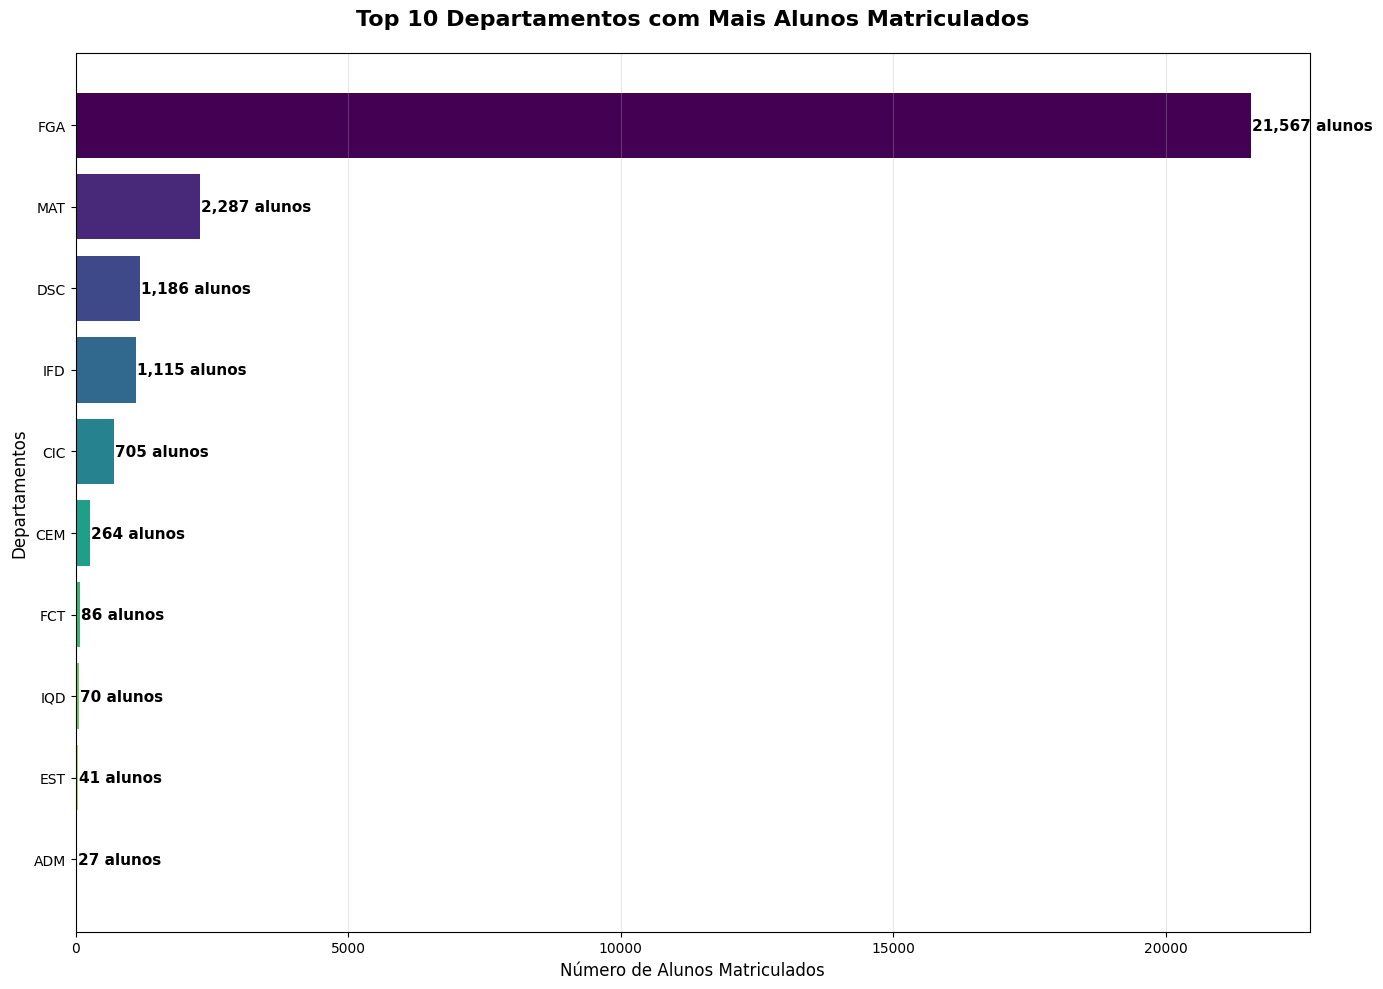

Top 10 Departamentos com Mais Alunos Matriculados:
Pos Departamento Alunos     Turmas   Disciplinas  Taxa Insucesso 
------------------------------------------------------------------------------------------
1   FGA          21,567     543      271          21.67          %
2   MAT          2,287      160      43           34.19          %
3   DSC          1,186      10       6            6.49           %
4   IFD          1,115      154      24           33.45          %
5   CIC          705        78       39           32.91          %
6   CEM          264        28       27           20.08          %
7   FCT          86         2        2            65.12          %
8   IQD          70         39       10           47.14          %
9   EST          41         29       13           68.29          %
10  ADM          27         25       15           40.74          %

Estatísticas do Top 10 Departamentos:
--------------------------------------------------
Total de alunos nos top 10: 27,3

In [ ]:
# Comentário: agregações por Departamento para comparar escala (alunos), oferta (turmas), quantidade de disciplinas e qualidade (taxa de insucesso). Visualização em barras horizontais e impressão de sumários.
dept_stats = dataframe.groupby('Departamento').agg({
    'Discentes': 'sum',
    'Turmas': 'sum',
    'Nome': 'count',
    'Total Insucesso': 'sum'
}).reset_index()

dept_stats['Taxa_Insucesso'] = (dept_stats['Total Insucesso'] / dept_stats['Discentes'] * 100).round(2)

top_10_dept = dept_stats.nlargest(10, 'Discentes')

plt.figure(figsize=(14, 10))

bars = plt.barh(range(len(top_10_dept)), top_10_dept['Discentes'], 
                color=plt.cm.viridis(np.linspace(0, 1, len(top_10_dept))))

for i, (bar, value) in enumerate(zip(bars, top_10_dept['Discentes'])):
    plt.text(bar.get_width() + 20, bar.get_y() + bar.get_height()/2, 
             f'{value:,} alunos', ha='left', va='center', fontweight='bold', fontsize=11)

plt.yticks(range(len(top_10_dept)), top_10_dept['Departamento'])
plt.xlabel('Número de Alunos Matriculados', fontsize=12)
plt.ylabel('Departamentos', fontsize=12)
plt.title('Top 10 Departamentos com Mais Alunos Matriculados', fontsize=16, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, axis='x')

plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print("Top 10 Departamentos com Mais Alunos Matriculados:")
print("=" * 90)
print(f"{'Pos':<3} {'Departamento':<12} {'Alunos':<10} {'Turmas':<8} {'Disciplinas':<12} {'Taxa Insucesso':<15}")
print("-" * 90)

for i, (_, row) in enumerate(top_10_dept.iterrows(), 1):
    print(f"{i:<3} {row['Departamento']:<12} {row['Discentes']:<10,} {row['Turmas']:<8} {row['Nome']:<12} {row['Taxa_Insucesso']:<15}%")

print(f"\nEstatísticas do Top 10 Departamentos:")
print("-" * 50)
print(f"Total de alunos nos top 10: {top_10_dept['Discentes'].sum():,}")
print(f"Média de alunos por departamento: {top_10_dept['Discentes'].mean():.1f}")
print(f"Departamento com mais alunos: {top_10_dept.iloc[0]['Departamento']} ({top_10_dept.iloc[0]['Discentes']:,} alunos)")
print(f"Departamento com menos alunos (top 10): {top_10_dept.iloc[-1]['Departamento']} ({top_10_dept.iloc[-1]['Discentes']:,} alunos)")

print(f"\nAnálise de Eficiência (Alunos por Turma):")
print("-" * 50)
top_10_dept['Alunos_por_Turma'] = (top_10_dept['Discentes'] / top_10_dept['Turmas']).round(1)
for _, row in top_10_dept.iterrows():
    print(f"{row['Departamento']}: {row['Alunos_por_Turma']} alunos/turma")

print(f"\nAnálise de Qualidade (Taxa de Insucesso):")
print("-" * 50)
dept_qualidade = top_10_dept.sort_values('Taxa_Insucesso')
for _, row in dept_qualidade.iterrows():
    print(f"{row['Departamento']}: {row['Taxa_Insucesso']}% de insucesso")

total_alunos_geral = dataframe['Discentes'].sum()
total_turmas_geral = dataframe['Turmas'].sum()
total_disciplinas_geral = len(dataframe)

print(f"\nComparação com Total Geral:")
print("-" * 40)
print(f"Top 10 departamentos representam:")
print(f"- {top_10_dept['Discentes'].sum() / total_alunos_geral * 100:.1f}% dos alunos totais")
print(f"- {top_10_dept['Turmas'].sum() / total_turmas_geral * 100:.1f}% das turmas totais")
print(f"- {top_10_dept['Nome'].sum() / total_disciplinas_geral * 100:.1f}% das disciplinas totais")
